# DTI derivatives QC in MICs

In [1]:
# Standard library imports
import os
import glob
import re

# Third-party library imports
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.collections import PolyCollection
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import spearmanr

# Local imports
from micapipe_fetch import *

def upper_tri_indexing(A):
    m = A.shape[0]
    r, c = np.triu_indices(m, 1)
    return A[r, c]

In [2]:
# Load fsLR-32k surface
surf_lh = fetch_surface('fsLR-32k.L.inflated.surf.gii')
surf_rh = fetch_surface('fsLR-32k.R.inflated.surf.gii')

# fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

# Derivatives directory
derivatives = "/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0"


## Set a list of subjects to load

In [3]:
# Suface from mapping one of the following: ["midthickness", "white", "swm1.0mm", 'swm2.0mm', "swm3.0mm"]
label = "midthickness"

# Standar surface (number of vertices): ["fsaverage5", "fsLR-32k", 'fsLR-5k']
surf = "fsLR-32k"

# Feature
feat = "FA"

# List of subjects with the desired feature
subject_list = sorted(glob.glob(
    os.path.join(derivatives, f"sub*/ses*/maps/*hemi-L_surf-{surf}_label-{label}_{feat}.func.gii*")))

## Load data

In [4]:
rows = []
data = []

pattern = re.compile(r"(sub-[^/]+).*?(ses-[^/]+)")

for i, path in enumerate(subject_list, start=1):
    
    # Extract sub and ses from path
    m = pattern.search(path)
    if not m:
        raise ValueError(f"Could not parse sub/ses from {path}")
    sub, ses = m.groups()
    
    # remove prefixes
    sub = sub.replace("sub-", "")
    ses = ses.replace("ses-", "")
    
    # micapipe fetcher
    fetcher = micapipe_fetch(derivatives=derivatives, sub=sub, ses=ses)
    feat_32k = fetcher.feat(surf=surf, feat=feat, label=label, concatenate=True)
        
    # read QC json
    qc_json_path = os.path.join(
        derivatives, f"sub-{sub}", f"ses-{ses}", "QC", f"sub-{sub}_ses-{ses}_module-proc_dwi.json"
    )
    qc_data = {}
    if os.path.exists(qc_json_path):
        with open(qc_json_path, "r") as f:
            qc_data = json.load(f)
    #else:
    #    print(f"⚠️ Missing QC JSON for sub-{sub}, ses-{ses}")

    # extract needed keys safely
    micapipeVersion = qc_data.get("micapipeVersion", None)
    user = qc_data.get("User", None)
    workstation = qc_data.get("Workstation", None)
    processing = qc_data.get("Processing", None)
    date = qc_data.get("Date", None)

    # read dwi preproc json
    preproc_json_path = os.path.join(
        derivatives, f"sub-{sub}", f"ses-{ses}", "dwi", f"sub-{sub}_ses-{ses}_desc-preproc_dwi.json"
    )
    preproc_data = {}
    if os.path.exists(preproc_json_path):
        with open(preproc_json_path, "r") as f:
            preproc_data = json.load(f)
    else:
        print(f"⚠️ Missing preproc JSON for sub-{sub}, ses-{ses}")

    regSynth = preproc_data.get("regSynth", None)

    # store metadata
    rows.append({
        "sub": sub,
        "ses": ses,
        "micapipeVersion": micapipeVersion,
        "User": user,
        "Workstation": workstation,
        "Processing": processing,
        "regSynth": regSynth,
        "Date": date
    })
    
    data.append(feat_32k)
    
    # calculate percentage
    percentage = (i / len(subject_list)) * 100
    print(f'Uploading progress: {percentage:.1f}% ({i}/{len(subject_list)})', end='\r')

# Make numeric matrix
X = np.vstack(data)  # shape = (n_samples, n_vertices)

# Metadata dataframe
meta = pd.DataFrame(rows)

# join matrix + metadata
df = pd.concat([meta, pd.DataFrame(X)], axis=1)

# mean FA per row (subject/session)
meta[f"mean{feat}"] = np.mean(X, axis=1)

# mean FA per vertex (column)
vertex_means = np.mean(X, axis=0)


Uploading progress: 100.0% (507/507)

In [5]:
# Note this is the same
print(f"Numpy array shape: {X.shape}")
df2 = df.drop(columns=["sub", "ses"])
Xdf = df2.to_numpy()
print(f"Pandas dataframe to np shape: {Xdf.shape}")


Numpy array shape: (507, 64984)
Pandas dataframe to np shape: (507, 64990)


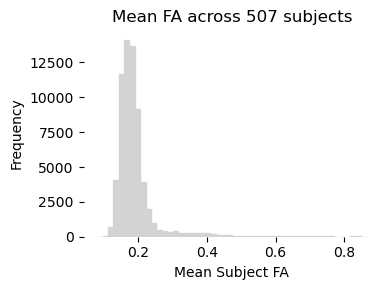

In [6]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, (ax) = plt.subplots(1, 1, figsize=(4, 3))
subject_means = np.mean(X, axis=1)

ax.hist(vertex_means, bins=50, color='lightgray', edgecolor='lightgray')
ax.set_title(f'Mean {feat} across {X.shape[0]} subjects')
ax.set_xlabel(f'Mean Subject {feat}')
ax.set_ylabel('Frequency')

# Remove the box (spines) from both plots
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


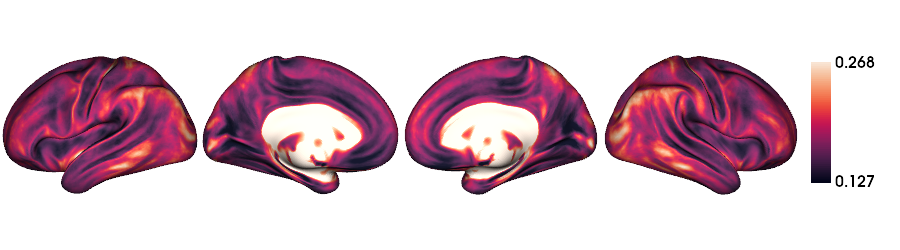

In [7]:
# Load fsLR-32k surface
surf_L_32k = fetch_surface('fsLR-32k.L.inflated.surf.gii')
surf_R_32k = fetch_surface('fsLR-32k.R.inflated.surf.gii')

# fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

# Get the color range
color_range=(np.quantile(vertex_means[fslr32k_mask], 0.01), np.quantile(vertex_means[fslr32k_mask], 0.99))

# Plot parcellations
plot_hemispheres(surf_L_32k, surf_R_32k, array_name=vertex_means, size=(900, 250), zoom=1.25, cmap='rocket',
                 embed_nb=True, color_bar='right', nan_color = [0,0,0,1], color_range=color_range)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_29917/1056410008.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_29917/1056410008.py:15: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_29917/1056410008.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


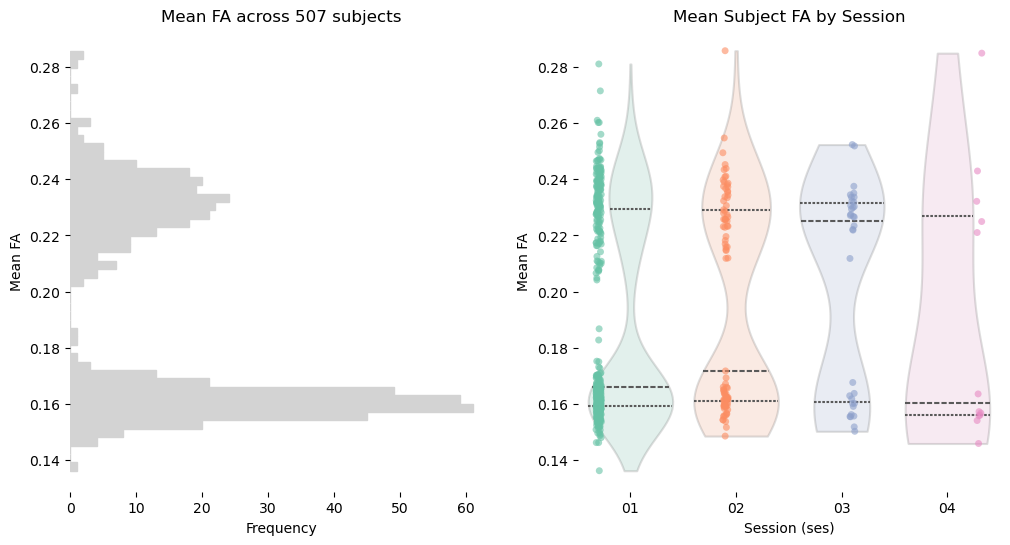

<Figure size 640x480 with 0 Axes>

In [8]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(12, 6))

# mean FA per row (subject/session)
ax1.hist(meta[f"mean{feat}"], bins=50, color='lightgray', edgecolor='lightgray', orientation='horizontal')
ax1.set_title(f'Mean {feat} across {X.shape[0]} subjects')
ax1.set_xlabel('Frequency')
ax1.set_ylabel(f'Mean {feat}')

# Remove spines
for spine in ax1.spines.values():
    spine.set_visible(False)

# Plot violins first (so points appear on top)
ax = sns.violinplot(
    x="ses",
    y=f"mean{feat}",
    data=meta,
    inner="quartile",   # Plot the quartile lines
    linewidth=1.5,
    cut=0,
    scale="width",
    palette="Set2",
    fill=True           # we need a filled body to make it transparent
)

# Overlay points (higher zorder so they sit on top of violins)
sns.stripplot(
    x="ses",
    y=f"mean{feat}",
    data=meta,
    jitter=True,
    dodge=True,
    alpha=0.6,
    palette="Set2",
    zorder=10
)

# Make only the violin bodies transparent (keep quartile lines fully opaque)
for coll in ax.collections:
    if isinstance(coll, PolyCollection):
        coll.set_alpha(0.2)   # 0 = fully transparent, 1 = opaque

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title(f"Mean Subject {feat} by Session")
ax.set_xlabel("Session (ses)")
ax.set_ylabel(f"Mean {feat}")
plt.show()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Similarity matrix

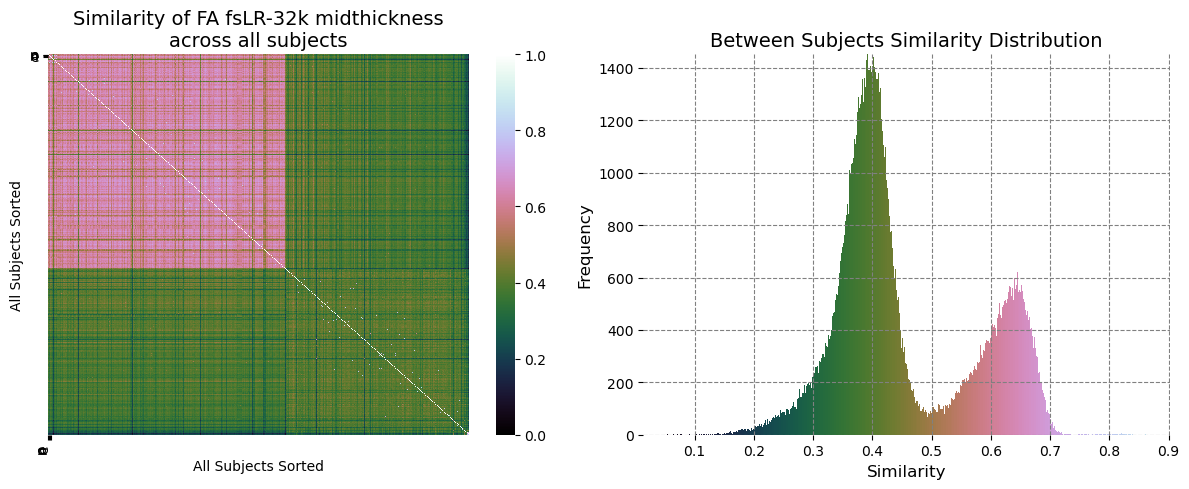

In [9]:
# compute row means
row_means = np.mean(X, axis=1)

# sort indices by row means
sort_idx = np.argsort(row_means)

# reorder everything
X_sorted = X[sort_idx, :]
meta_sorted = meta.iloc[sort_idx].reset_index(drop=True)
row_means_sorted = row_means[sort_idx]

# correlation across SUBJECTS (rows)
corr = np.corrcoef(X_sorted)

# build combined labels (sub_ses)
labels = meta_sorted["sub"] + "_ses-" + meta_sorted["ses"]

# get upper triangle (no diagonal)
corr_sym = upper_tri_indexing(corr)


# --- create 1x2 layout ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # adjust size as needed

# --- left: heatmap ---
sns.heatmap(
    corr,
    ax=ax1,
    cmap="cubehelix",
    vmin=0, vmax=1,
    xticklabels='none',
    yticklabels='none'
)
ax1.set_xlabel("All Subjects Sorted")
ax1.set_ylabel("All Subjects Sorted")
ax1.set_title(f"Similarity of {feat} {surf} {label}\nacross all subjects", fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, ha='right')

# --- right: histogram of upper triangle ---
corr_sym = upper_tri_indexing(corr)  # function you already have
n, bins = np.histogram(corr_sym, bins=corr.shape[0])
bin_centers = (bins[:-1] + bins[1:]) / 2
colored_bins = cm.cubehelix(np.interp(bin_centers, [0, 1], [0, 1]))

ax2.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, align="center")
ax2.set_xlabel("Similarity", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_title("Between Subjects Similarity Distribution", fontsize=14)
ax2.grid(color="gray", linestyle="dashed", zorder=0)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.set_ylim(0, np.max(n))

# --- adjust spacing ---
plt.tight_layout()
plt.show()


# Insight into the bivariate distribution

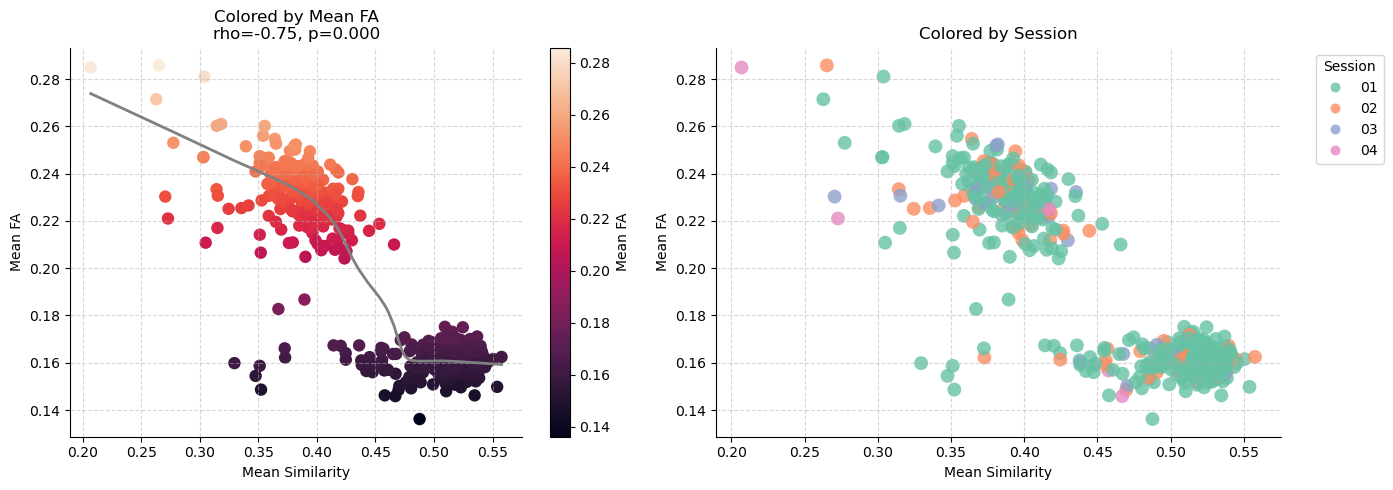

In [10]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# correlation across SUBJECTS (rows)
corr = np.corrcoef(X)

# Compute mean similarity
meta["meanSim"] = np.mean(corr, axis=0)

# Compute Spearman correlation
rho, pval = spearmanr(meta["meanSim"], meta[f"mean{feat}"])

# Create 1x2 layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Scatter 1: color by mean{feat} ---
sc1 = ax1.scatter(
    meta["meanSim"], meta[f"mean{feat}"],
    c=meta[f"mean{feat}"],
    cmap="rocket",
    s=80,
    edgecolor='none'
)

# Fit LOESS
loess_smoothed = lowess(
    meta[f"mean{feat}"],
    meta["meanSim"],
    frac=0.5 )

# Plot LOESS line
ax1.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color='gray', linewidth=2, label='LOESS fit')

ax1.set_xlabel("Mean Similarity")
ax1.set_ylabel(f"Mean {feat}")
ax1.set_title(f"Colored by Mean {feat}\nrho={rho:.2f}, p={pval:.3f}")
fig.colorbar(sc1, ax=ax1, label=f"Mean {feat}")
ax1.grid(True, linestyle='--', alpha=0.5)
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)

# --- Scatter 2: color by session ---
# Get Seaborn Set2 palette with correct number of sessions
ses_categories = meta['ses'].astype('category')
ses_labels = ses_categories.cat.categories
palette = sns.color_palette("Set2", n_colors=len(ses_labels))

# Map each session to its color
color_map = dict(zip(ses_labels, palette))
point_colors = meta['ses'].map(color_map)

# Scatter plot with exact same colors as Seaborn stripplot
sc2 = ax2.scatter(
    meta["meanSim"], meta[f"mean{feat}"],
    c=point_colors,
    s=100,
    edgecolor='none',
    alpha=0.8
)

# Create legend with exact same colors
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=color_map[label], markersize=8, alpha=0.8)
           for label in ses_labels]
ax2.legend(handles=handles, title="Session", bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_xlabel("Mean Similarity")
ax2.set_ylabel(f"Mean {feat}")
ax2.set_title("Colored by Session")
ax2.grid(True, linestyle='--', alpha=0.5)
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Getting the centroids

In [11]:
# Features for clustering
X_hac = meta[[f"mean{feat}", "meanSim"]].values

# Compute linkage matrix (Ward method is common for Euclidean distances)
Z = linkage(X_hac, method='ward', metric='euclidean')

# Assign clusters (k=2)
meta["cluster_hac"] = fcluster(Z, t=2, criterion='maxclust')

# Number of points to assign as "centers" per cluster
n_closest = 20

# Initialize 'centers' variable with zeros
meta["centers"] = 0

# Compute cluster centroids
centroids = meta.groupby("cluster_hac")[[f"mean{feat}", "meanSim"]].mean()

# For each cluster, find the N observations closest to its centroid
for cluster_id, centroid in centroids.iterrows():
    cluster_points = meta[meta["cluster_hac"] == cluster_id][[f"mean{feat}", "meanSim"]]
    # Compute Euclidean distances to centroid
    distances = np.linalg.norm(cluster_points.values - centroid.values, axis=1)
    # Get indices of the closest N points
    closest_idx = cluster_points.index[np.argsort(distances)[:n_closest]]
    # Assign cluster ID to 'centers'
    meta.loc[closest_idx, "centers"] = cluster_id

# Check summary
print(meta["centers"].value_counts())

centers
0    467
2     20
1     20
Name: count, dtype: int64


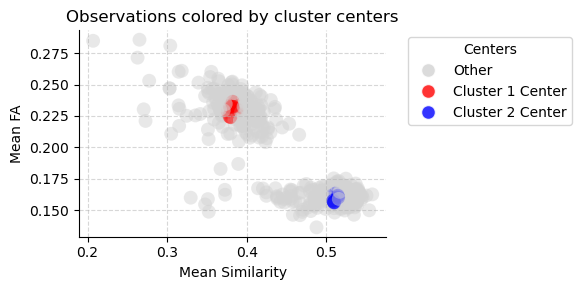

In [12]:
# Define colors for centers: 0 = gray, 1 = red, 2 = blue (or any palette you like)
center_palette = {0: "lightgray", 1: "red", 2: "blue"}
point_colors = meta['centers'].map(center_palette)

plt.figure(figsize=(6, 3))
sc = plt.scatter(
    meta["meanSim"], 
    meta[f"mean{feat}"],
    c=point_colors,
    s=100,
    edgecolor='none',   # optional: black edge for visibility
    alpha=0.5
)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=color, markersize=10, alpha=0.8)
           for label, color in zip(['Other', 'Cluster 1 Center', 'Cluster 2 Center'], ['lightgray','red','blue'])]
plt.legend(handles=handles, title="Centers", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Mean Similarity")
plt.ylabel(f"Mean {feat}")
plt.title("Observations colored by cluster centers")
plt.grid(True, linestyle='--', alpha=0.5)

# Remove top/right spines for style
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
# Subset to cluster 1 centers
cluster1_data = meta[meta["centers"] == 1].index
df_cluster1 = df.loc[cluster1_data].drop(columns=["sub", "ses", "micapipeVersion", "User", "Workstation", "Processing", "regSynth", "Date"])

# Subset to cluster 2 centers
cluster2_data = meta[meta["centers"] == 2].index
df_cluster2 = df.loc[cluster2_data].drop(columns=["sub", "ses",  "micapipeVersion", "User", "Workstation", "Processing", "regSynth", "Date"])

# Add unique identifier
meta["id"] = meta["sub"].astype(str) + "_" + meta["ses"].astype(str)


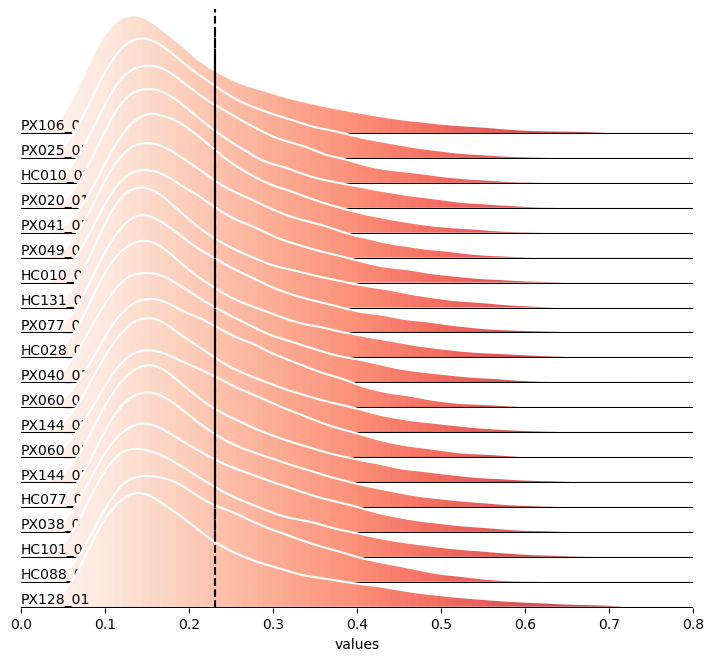

In [18]:
ridgeplot(df_cluster1.to_numpy(), Cmap="Reds", mean_line=True, color_range=(0, 0.8), 
                  matrix_df=meta[meta["centers"] == 1], label_pos=0.0)

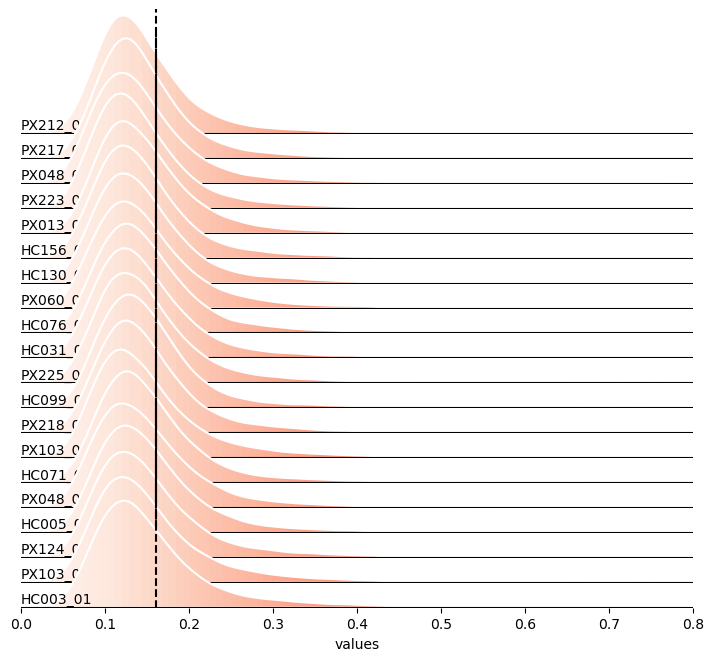

In [19]:
ridgeplot(df_cluster2.to_numpy(), Cmap="Reds", mean_line=True, color_range=(0, 0.8), 
                  matrix_df=meta[meta["centers"] == 2], label_pos=0.0)

In [20]:
meta[meta["centers"] == 1].drop(columns=["micapipeVersion", "id", "cluster_hac"])

,sub,ses,User,Workstation,Processing,regSynth,Date,meanFA,meanSim,centers
12,HC010,02,kexie,valentine.bic.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Sun Aug 27 03:30:02 EDT 2023,0.225804,0.386412,1
13,HC010,03,kexie,yeatman.bic.mni.mcgill.ca,container_micapipe-v0.2.0,FALSE,Tue Aug 22 04:14:58 EDT 2023,0.229942,0.379014,1
38,HC028,01,kexie,oncilla.bic.mni.mcgill.ca,container_micapipe-v0.2.0,FALSE,Tue Aug 22 05:06:37 EDT 2023,0.231595,0.379870,1
114,HC077,01,esahlas,montano.bic-wks.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Sun Mar 10 08:31:26 EDT 2024,0.233698,0.383588,1
135,HC088,02,esahlas,montano.bic-wks.mni.mcgill.ca,container_micapipe-v0.2.3,FALSE,Fri Aug 23 12:59:52 EDT 2024,0.235471,0.385042,1
151,HC101,01,jroyer,varro.bic.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Tue Aug 8 15:50:37 EDT 2023,0.234418,0.377649,1
183,HC131,01,esahlas,montano.bic-wks.mni.mcgill.ca,container_micapipe-v0.2.3,FALSE,Mon Dec 2 19:03:40 EST 2024,0.230484,0.388253,1
251,PX020,01,kexie,percy.bic.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Sun Aug 27 22:15:58 EDT 2023,0.228194,0.375984,1
258,PX025,01,esahlas,oncilla.bic.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Mon Sep 18 17:38:27 EDT 2023,0.224765,0.378170,1
283,PX038,01,esahlas,montano.bic.mni.mcgill.ca,container_micapipe-v0.2.2,FALSE,Wed Sep 20 22:11:16 EDT 2023,0.234362,0.385173,1


In [17]:
meta[meta["centers"] == 2].drop(columns=["micapipeVersion", "id", "cluster_hac"])

,sub,ses,User,Workstation,Processing,regSynth,Date,meanFA,meanSim,centers
3,HC003,01,esahlas,node25.bic.mni.mcgill.ca,container_micapipe-v0.2.0,TRUE,Wed Jun 28 21:57:29 EDT 2023,0.164550,0.509675,2
5,HC005,02,esahlas,node24.bic.mni.mcgill.ca,container_micapipe-v0.2.0,TRUE,Wed Jun 28 23:04:32 EDT 2023,0.162270,0.511209,2
43,HC031,01,judyc,varro.bic.mni.mcgill.ca,container_micapipe-v0.2.0,TRUE,Thu Jul 6 16:23:12 EDT 2023,0.159836,0.512702,2
104,HC071,03,esahlas,cassio.bic-wks.mni.mcgill.ca,container_micapipe-v0.2.3,TRUE,Wed Feb 14 23:48:55 EST 2024,0.161802,0.511656,2
110,HC076,01,jroyer,venice.bic.mni.mcgill.ca,container_micapipe-v0.2.0,TRUE,Sat Jul 8 16:56:09 EDT 2023,0.159803,0.514928,2
149,HC099,01,jroyer,percy.bic.mni.mcgill.ca,container_micapipe-v0.2.2,TRUE,Thu Aug 17 20:23:10 EDT 2023,0.160277,0.511248,2
182,HC130,02,esahlas,varro.bic-wks.mni.mcgill.ca,container_micapipe-v0.2.3,TRUE,Sat Jan 25 19:49:33 EST 2025,0.159404,0.508591,2
207,HC156,01,esahlas,bb-comp.bic-node.mni.mcgill.ca,container_micapipe-v0.2.3,TRUE,Tue Mar 11 11:56:22 EDT 2025,0.159048,0.513998,2
236,PX013,01,kexie,peto.bic.mni.mcgill.ca,container_micapipe-v0.2.0,TRUE,Wed Jul 5 03:07:35 EDT 2023,0.158869,0.511459,2
298,PX048,01,jroyer,oncilla.bic.mni.mcgill.ca,container_micapipe-v0.2.2,TRUE,Fri Aug 25 16:58:51 EDT 2023,0.162033,0.514270,2


In [ ]:
# --- Scatter 2: color by regSynth ---
fig, ax2 = plt.subplots(figsize=(6, 5))
# Convert regSynth column to categorical
reg_categories = meta['regSynth'].astype('category')
reg_labels = reg_categories.cat.categories

# Build Set2 palette with as many colors as unique regSynth values
palette = sns.color_palette("Set2", n_colors=len(reg_labels))

# Map each regSynth to its color
color_map = dict(zip(reg_labels, palette))
point_colors = meta['regSynth'].map(color_map)

# Scatter plot with regSynth-based colors
sc2 = ax2.scatter(
    meta["meanSim"], meta[f"mean{feat}"],
    c=point_colors,
    s=100,
    edgecolor='none',
    alpha=0.8
)

# --- Counts per group ---
counts = meta['regSynth'].value_counts().reindex(reg_labels)

# Legend handles with counts
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w',
        label=f"{label} (n={counts[label]})",
        markerfacecolor=color_map[label],
        markersize=8, alpha=0.8
    )
    for label in reg_labels
]

ax2.legend(handles=handles, title="regSynth", bbox_to_anchor=(1.05, 1), loc='upper left')

# Labels and styling
ax2.set_xlabel("Mean Similarity", fontsize=12)
ax2.set_ylabel(f"Mean {feat}", fontsize=12)
ax2.set_title("regSynth", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
meta.to_csv('/home/bic/rcruces/Desktop/micapipe_MICs_metadata_flair.csv', index=False)

In [ ]:
from scipy.stats import gaussian_kde

# Flatten the matrix
Xval = df_cluster2.to_numpy()

# Compute KDE
kde = gaussian_kde(Xval)
x_grid = np.linspace(np.min(Xval), np.max(Xval), 1000)
y = kde(x_grid)

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Normalize x values for colormap
norm = plt.Normalize(vmin=np.min(Xval), vmax=np.max(Xval))
colors = cm.Reds(norm(x_grid))

# Plot KDE with color gradient
for i in range(len(x_grid) - 1):
    ax.fill_between(x_grid[i:i+2], y[i:i+2], color=colors[i], edgecolor='none')

# Set axis limits and labels
ax.set_xlim(np.min(Xval), np.max(Xval))
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title(f"{meta.loc[df_cluster2.index, 'id'].values[0]} {feat} {surf} {label}", fontsize=14)

# Add grid with dashed lines
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()